# Unsupervised learning

### AutoEncoders  

An autoencoder, is an artificial neural network used for learning efficient codings. 

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

<img src="../imgs/autoencoder.png" width="25%">

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data.

### Reference

Based on [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

## Introducing _Keras Functional API_

The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

All the Functional API relies on the fact that each `keras.Layer` object is a _callable_ object!

See <a title="8.2 Multi-Modal Networks" href="../8. Extra/8.2 Multi-Modal Networks.ipynb">8.2 Multi-Modal Networks</a> for further details.

(**NOT AVAILABLE YET**)

---

## AutoEncoders in Keras

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist

import numpy as np

Using TensorFlow backend.


In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [8]:
#note: x_train, x_train :) 
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.3635 - val_loss: 0.2706
Epoch 2/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2626 - val_loss: 0.2509
Epoch 3/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2400 - val_loss: 0.2275
Epoch 4/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2200 - val_loss: 0.2106
Epoch 5/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2058 - val_loss: 0.1988
Epoch 6/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1960 - val_loss: 0.1904
Epoch 7/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1884 - val_loss: 0.1836
Epoch 8/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1820 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1763 - val_loss: 0.1721
Epoch

#### Testing the Autoencoder 

In [9]:
from matplotlib import pyplot as plt

%matplotlib inline

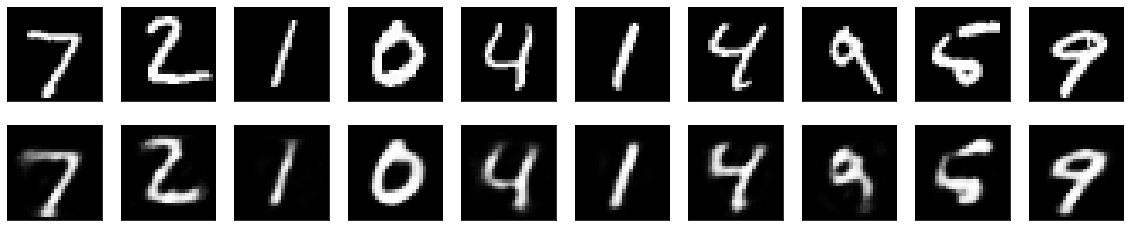

In [10]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Sample generation with Autoencoder 

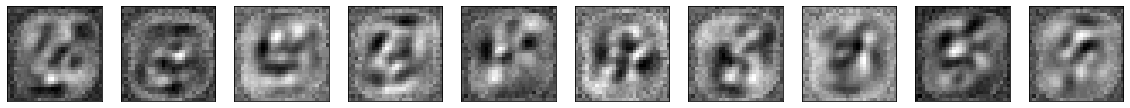

In [11]:
encoded_imgs = np.random.rand(10,32)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

## Convolutional AutoEncoder

Since our inputs are images, it makes sense to use convolutional neural networks (`convnets`) as encoders and decoders. 

In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.



In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
from keras import backend as K

if K.image_data_format() == 'channels_last':
    shape_ord = (28, 28, 1)
else:
    shape_ord = (1, 28, 28)
    
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, ((x_train.shape[0],) + shape_ord))  
x_test = np.reshape(x_test, ((x_test.shape[0],) + shape_ord)) 

In [14]:
x_train.shape

(60000, 28, 28, 1)

In [15]:
from keras.callbacks import TensorBoard

In [16]:
batch_size=128
steps_per_epoch = np.int(np.floor(x_train.shape[0] / batch_size))
conv_autoencoder.fit(x_train, x_train, epochs=50, batch_size=128,
                     shuffle=True, validation_data=(x_test, x_test),
                     callbacks=[TensorBoard(log_dir='./tf_autoencoder_logs')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.2039 - val_loss: 0.1590
Epoch 2/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.1507 - val_loss: 0.1398
Epoch 3/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.1379 - val_loss: 0.1309
Epoch 4/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1309 - val_loss: 0.1308
Epoch 5/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.1260 - val_loss: 0.1259
Epoch 6/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.1227 - val_loss: 0.1287
Epoch 7/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.1200 - val_loss: 0.1149
Epoch 8/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.1178 - val_loss: 0.1141
Epoch 9/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.1160 - val_loss: 0.1120
Epoc

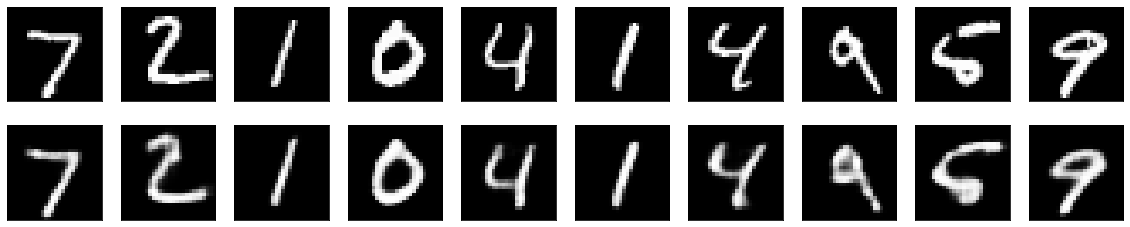

In [17]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We coudl also have a look at the `128-`dimensional encoded middle representation

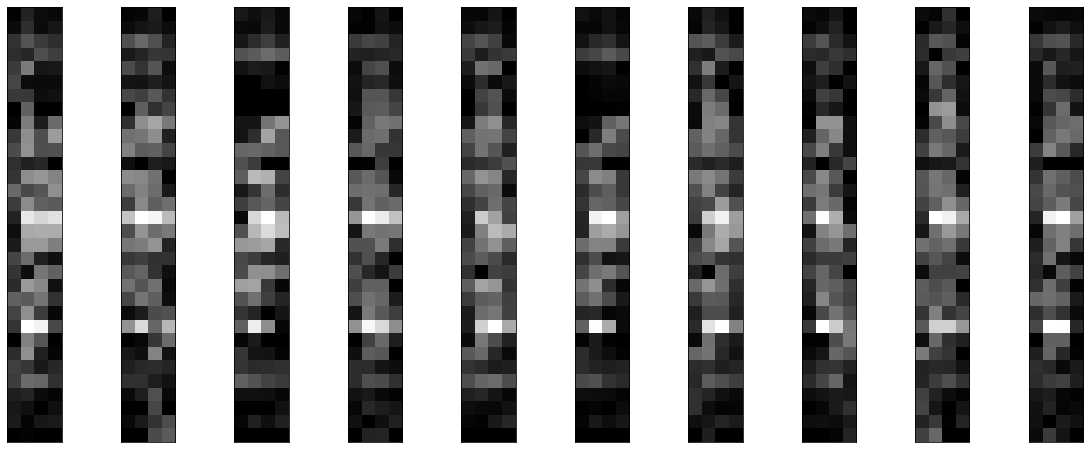

In [18]:
conv_encoder = Model(input_img, encoded)
encoded_imgs = conv_encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Pretraining encoders 

One of the powerful tools of auto-encoders is using the encoder to generate meaningful representation from the feature vectors.

In [ ]:
# Use the encoder to pretrain a classifier 

---

## Application to Image Denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [19]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's how the noisy digits look like:

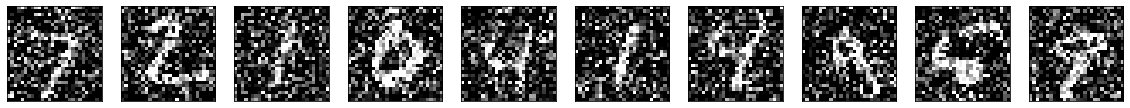

In [20]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Question

If you squint you can still recognize them, but barely. 

**Can our autoencoder learn to recover the original digits? Let's find out.**

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

from keras.callbacks import TensorBoard

In [22]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train the AutoEncoder for `100` epochs

In [23]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_denoise', 
                                       histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 142us/step - loss: 0.1751 - val_loss: 0.1234
Epoch 2/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.1188 - val_loss: 0.1130
Epoch 3/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.1113 - val_loss: 0.1084
Epoch 4/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.1080 - val_loss: 0.1061
Epoch 5/100
60000/60000 [==============================] - 8s 133us/step - loss: 0.1056 - val_loss: 0.1059
Epoch 6/100
60000/60000 [==============================] - 8s 135us/step - loss: 0.1041 - val_loss: 0.1017
Epoch 7/100
60000/60000 [==============================] - 8s 136us/step - loss: 0.1032 - val_loss: 0.1003
Epoch 8/100
60000/60000 [==============================] - 8s 138us/step - loss: 0.1022 - val_loss: 0.1023
Epoch 9/100
60000/60000 [==============================] - 8s 139us/step - loss: 0.1016 - val_

### Now Let's Take a look....

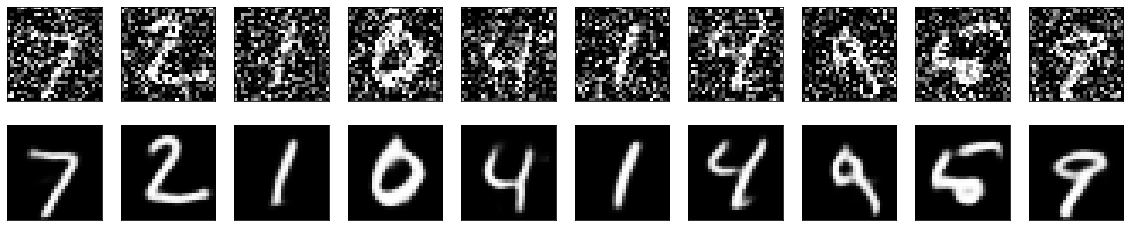

In [25]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational AutoEncoder

_(Reference [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html))_

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

### What is a variational autoencoder ? 

It's a type of autoencoder with added constraints on the encoded representations being learned. 

More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data. 

So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. 

If you sample points from this distribution, you can generate new input data samples: 
a **VAE** is a **"generative model"**.

### How does a variational autoencoder work?

First, an encoder network turns the input samples $x$ into two parameters in a latent space, which we will note $z_{\mu}$ and $z_{log_{\sigma}}$. 

Then, we randomly sample similar points $z$ from the _latent normal distribution_ that is assumed to generate the data, via $z = z_{\mu} + \exp(z_{log_{\sigma}}) * \epsilon$, where $\epsilon$ is a random normal tensor. 

Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: 

* a **reconstruction loss** forcing the decoded samples to match the initial inputs (just like in our previous autoencoders);
* and the **KL divergence** between the learned latent distribution and the prior distribution, acting as a regularization term. 

You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

## Encoder Network

In [28]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 500
epsilon_std = 1.0

In [29]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_var')(h)

We can use these parameters to sample new similar points from the latent space:

In [30]:
from keras.layers.core import Lambda
from keras import backend as K

In [31]:
def sampling(args):
    
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

## Decoder Network

Finally, we can map these sampled latent points back to reconstructed inputs:

In [32]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

In [33]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### Let's Visualise the VAE Model

#### Note: the module `pydot-ng` is required!

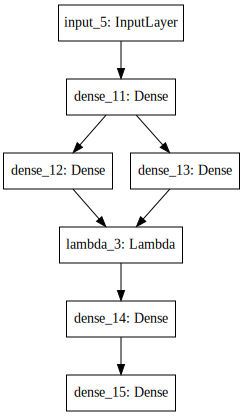

In [34]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [35]:
## Exercise: Let's Do the Same for `encoder` and `generator` Model(s)



### VAE on MNIST

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [36]:
from keras.objectives import binary_crossentropy

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adadelta', loss=vae_loss)

### Traing on MNIST Digits

##### Notes: This will take a bit! Please consider to switch to GPU for better results

In [41]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 2/500
60000/60000 [==============================] - 2s 39us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 3/500
60000/60000 [==============================] - 2s 39us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 4/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 5/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 6/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 7/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 8/500
60000/60000 [==============================] - 2s 41us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 9/500
60000/60000 [==============================] - 2s 41us/step - loss: 0.2628 - val_loss: 0.2

60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 154/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 155/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 156/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 157/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 158/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 159/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 160/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 161/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 162/500
60000/60000 [===============

Epoch 229/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 230/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 231/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 232/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 233/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 234/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 235/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 236/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 237/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 238/500
60000/60000 [=

Epoch 305/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 306/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 307/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 308/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 309/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 310/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 311/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 312/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 313/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 314/500
60000/60000 [=

Epoch 381/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 382/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 383/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 384/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 385/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 386/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 387/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 388/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 389/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 390/500
60000/60000 [=

Epoch 457/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 458/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 459/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 460/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 461/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 462/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 463/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 464/500
60000/60000 [==============================] - 3s 42us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 465/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.2628 - val_loss: 0.2625
Epoch 466/500
60000/60000 [=

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. 

One is to look at the neighborhoods of different classes on the latent 2D plane:

In [42]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

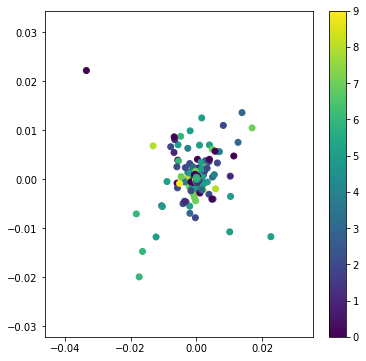

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).


Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

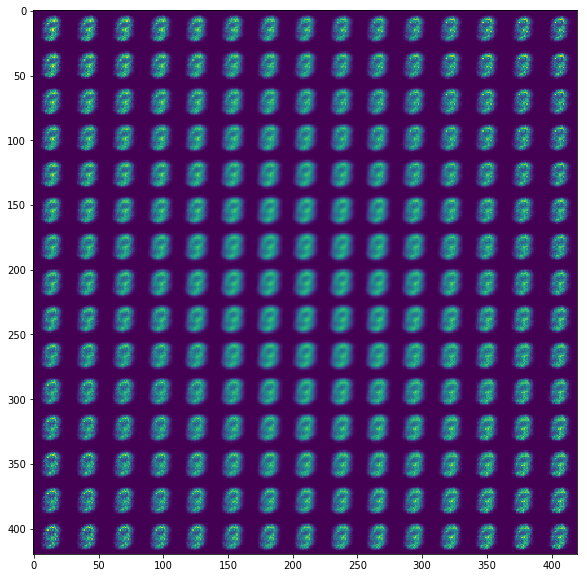

In [44]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()